# Mini Project 2

In [4]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.optimize import minimize
import datetime as dict
import scipy.stats as stats

YF.download() has changed argument auto_adjust default to True
Trimmed from 1255 to 1229 data points


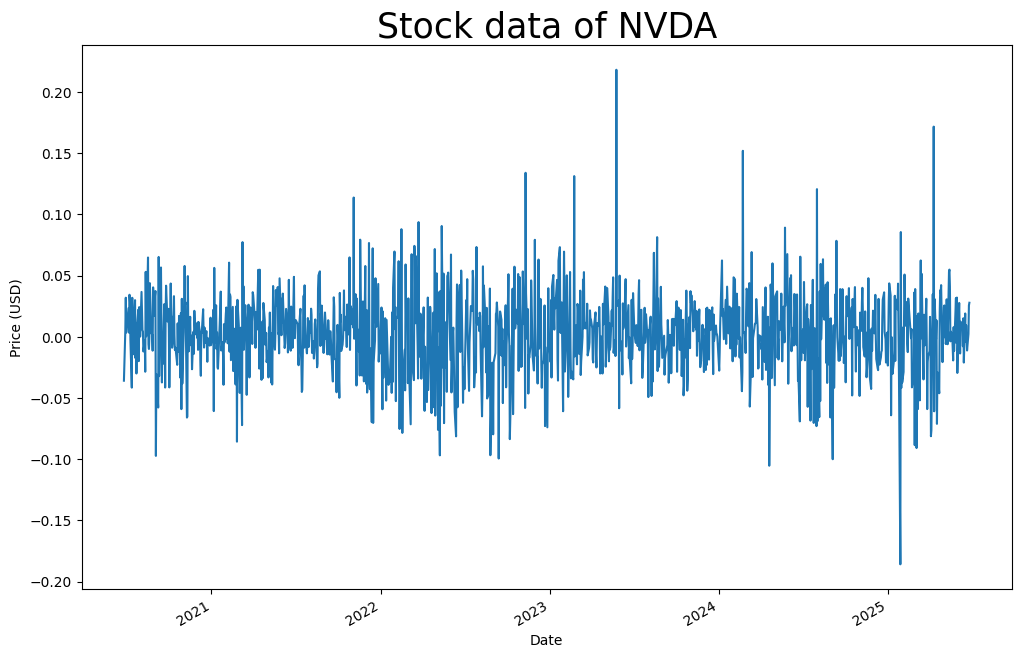

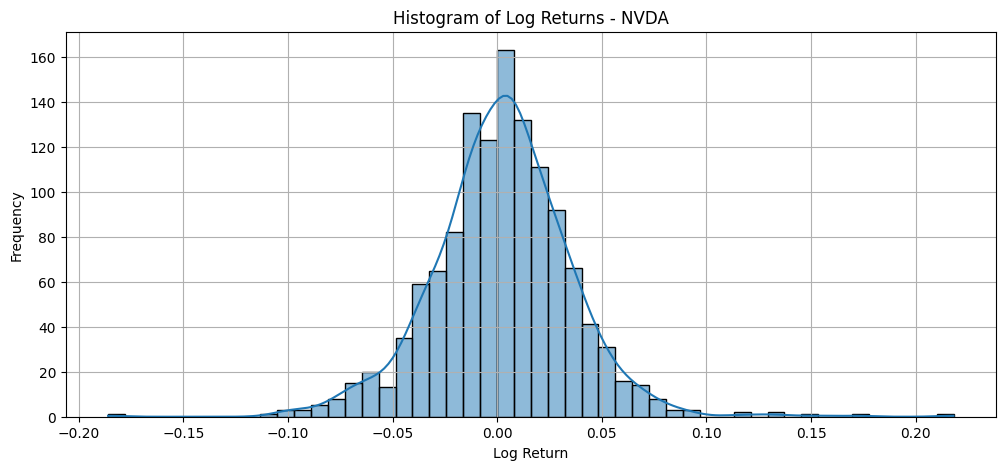

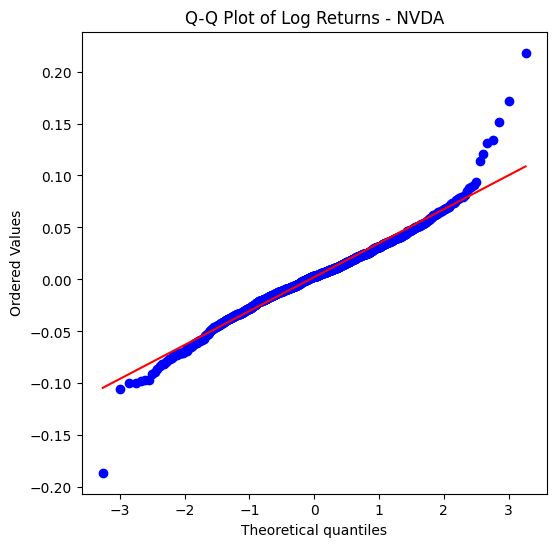

In [5]:
#download
tickers = ['NVDA', 'AMZN', 'TSLA', 'META', 'GOOG',  # Generally more volatile tech stocks
           'JNJ', 'KO', 'PG', 'HD', 'MCD']          # More stable, defensive companies

data = yf.download(tickers, period = "5y", interval = "1d", progress = False)

close = data["Close"]
normalized_returns = close/close.iloc[0]-1 #moves sotck prices to a start of 0

#create multiindex columns for new data

normalized_returns.columns = pd.MultiIndex.from_product([['Cumulative Return'], normalized_returns.columns])
data = pd.concat([data, normalized_returns], axis = 1)

#Calculate log daily returns
log_returns = np.log(close / close.shift(1))
log_returns = log_returns.dropna()

#add to main df
log_returns.columns = pd.MultiIndex.from_product([['Log Returns'], log_returns.columns])
data = pd.concat([data, log_returns], axis = 1)

#  1) Test if there are period of times when the log-returns of a stock/index have evidence of normal distribution.
stock_name = 'NVDA'

log_returns["Log Returns", stock_name].plot(figsize=(12,8))

plt.title(f'Stock data of {stock_name}', size = 25)
plt.ylabel("Price (USD)")

#Extract log returns for NVDA
stock_returns = log_returns['Log Returns', stock_name]

#Remove outliers

stock_trimmed = stock_returns.copy()

lower_bound = stock_trimmed.quantile(0.01)
upper_bound = stock_trimmed.quantile(0.99)

#Keep only the central 98%
stock_trimmed = stock_trimmed[(stock_trimmed >= lower_bound) & (stock_trimmed <= upper_bound)]
print(f"Trimmed from {len(stock_returns)} to {len(stock_trimmed)} data points")


#Histogram
plt.figure(figsize=(12,5))
sns.histplot(stock_returns, bins = 50, kde = True)
plt.title(f"Histogram of Log Returns - {stock_name}")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

#QQ Plot
plt.figure(figsize=(6,6))
stats.probplot(stock_returns, dist = "norm", plot = plt)
plt.title(f"Q-Q Plot of Log Returns - {stock_name}")
plt.show()

Shapiro-Wilk Test for NVDA
Test Statistic = 0.9709
p-value = 3.3432e-15
Reject the null hypothesis: log returns are not normally distributed
Anderson Darling Test for NVDA
Test Statistic: 4.7434
Critical Values (significance levels 15%, 10%, 5%, 2.5%, 1%):
  15.0%: 0.5740 → Reject H_0
  10.0%: 0.6540 → Reject H_0
   5.0%: 0.7850 → Reject H_0
   2.5%: 0.9150 → Reject H_0
   1.0%: 1.0890 → Reject H_0

Jarque-Bera Test for NVDA
Test Statistic = 610.05
p-value = 0.0000e+00
Reject the null: not normal
69.73% of 60-day windows passed the Shapiro-Wilk normality test.


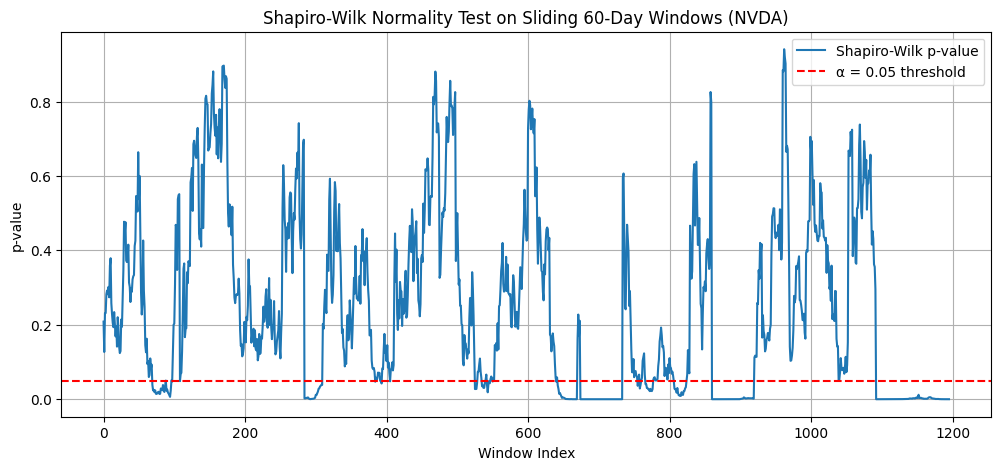

In [7]:
shapiro_stat, shapiro_p = stats.shapiro(stock_returns)

print(f"Shapiro-Wilk Test for {stock_name}")
print(f"Test Statistic = {shapiro_stat:.4f}")
print(f"p-value = {shapiro_p:.4e}")

if shapiro_p < 0.05:
    print("Reject the null hypothesis: log returns are not normally distributed")
else:
    print("Fail to reject the null hypothesis: log returns may be normally distributed")

    #Anderson-Darling (A-D)

from scipy.stats import anderson

ad_result = anderson(stock_returns, dist = 'norm')

print(f"Anderson Darling Test for {stock_name}")
print(f"Test Statistic: {ad_result.statistic:.4f}")
print("Critical Values (significance levels 15%, 10%, 5%, 2.5%, 1%):")

for s1, cv in zip(ad_result.significance_level, ad_result.critical_values):
    sig = "Reject H_0" if ad_result.statistic > cv else "Fail to reject H_0"
    print(f"  {s1:>4.1f}%: {cv:.4f} → {sig}")

from scipy.stats import jarque_bera

jb_stat, jb_p = jarque_bera(stock_returns)

print(f"\nJarque-Bera Test for {stock_name}")
print(f"Test Statistic = {jb_stat:.2f}")
print(f"p-value = {jb_p:.4e}")

if jb_p < 0.05:
    print("Reject the null: not normal")
else:
    print(" Fail to reject the null: could be normal.")

#Sliding Window normality function

def sliding_shapiro_test(returns, window_size = 60):
    results = []

    for start in range(0, len(returns) - window_size + 1):
        end = start + window_size
        window = returns[start:end]
        _, p_value = stats.shapiro(window)
        results.append(p_value)

    return np.array(results)


#Test the function
stock_p_values = sliding_shapiro_test(stock_returns, window_size=60)

#determine which windows passed (p>=0.05)
stock_passed = stock_p_values >= 0.05

#What % passed the test?
percent_passed = np.mean(stock_passed) * 100
print(f"{percent_passed:.2f}% of 60-day windows passed the Shapiro-Wilk normality test.")

plt.figure(figsize=(12, 5))
plt.plot(stock_p_values, label="Shapiro-Wilk p-value")
plt.axhline(0.05, color='red', linestyle='--', label="α = 0.05 threshold")
plt.title("Shapiro-Wilk Normality Test on Sliding 60-Day Windows (NVDA)")
plt.xlabel("Window Index")
plt.ylabel("p-value")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
def sliding_shapiro_test(returns, window_size = 60):
    results = []
    windows = []

    for start in range(0, len(returns) - window_size + 1):
        end = start + window_size
        window = returns[start:end]
        _, p_value = stats.shapiro(window)
        results.append(p_value)

        #Store the date range
        start_date = returns.index[start]
        end_date = returns.index[end -1]
        windows.append((start_date, end_date))

    return np.array(results), windows


def normality_test(stock_name, show_plots=True):
    results = {}

    # Extract log returns
    stock_returns = log_returns['Log Returns', stock_name]

    # Trim outliers (1% tails)
    lower_bound = stock_returns.quantile(0.01)
    upper_bound = stock_returns.quantile(0.99)
    stock_trimmed = stock_returns[(stock_returns >= lower_bound) & (stock_returns <= upper_bound)]

    # Store count of data points
    results['Ticker'] = stock_name
    results['Original N'] = len(stock_returns)
    results['Trimmed N'] = len(stock_trimmed)

    # === Shapiro-Wilk ===
    sh_stat, sh_p = stats.shapiro(stock_returns)
    results['Shapiro Stat'] = sh_stat
    results['Shapiro p'] = sh_p

    # === Anderson-Darling ===
    ad_result = anderson(stock_returns, dist='norm')
    results['Anderson Stat'] = ad_result.statistic

    # Use 5% level
    cv_5 = ad_result.critical_values[2]
    results['Anderson CV (5%)'] = cv_5
    results['Anderson Reject @5%'] = ad_result.statistic > cv_5

    # === Jarque-Bera ===
    jb_stat, jb_p = jarque_bera(stock_returns)
    results['Jarque-Bera Stat'] = jb_stat
    results['Jarque-Bera p'] = jb_p

    #D'Agostino and Pearson Test
    from scipy.stats import normaltest
    dp_stat, p_dp = stats.normaltest(stock_returns)
    results['DP Stat'] = dp_stat
    results['DP P'] = p_dp

    # === Sliding Windows ===
    window_p_vals, windows = sliding_shapiro_test(stock_returns, window_size=60)

    # Filter out windows that passed (p >= 0.05)
    passed_windows = [(start, end) for p, (start, end) in zip(window_p_vals, windows) if p >= 0.05]
    passed_df = pd.DataFrame(passed_windows, columns=["Start Date", "End Date"])

    # Display top 5 as a preview
    for i, (start, end) in enumerate(passed_windows[:5]):
        print(f"Window {i+1}: {start.date()} to {end.date()}")

    percent_passed = np.mean(window_p_vals >= 0.05) * 100
    results['% Windows Normal'] = percent_passed

    # === Plots (optional) ===
    if show_plots:
        plt.figure(figsize=(12, 5))
        sns.histplot(stock_returns, bins=50, kde=True)
        plt.title(f"Histogram of Log Returns - {stock_name}")
        plt.show()

        plt.figure(figsize=(6, 6))
        stats.probplot(stock_returns, dist="norm", plot=plt)
        plt.title(f"Q-Q Plot of Log Returns - {stock_name}")
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(12, 5))
        plt.plot(window_p_vals, label="Shapiro-Wilk p-value")
        plt.axhline(0.05, color='red', linestyle='--', label="α = 0.05 threshold")
        plt.title(f"Sliding Shapiro-Wilk Test - {stock_name}")
        plt.xlabel("Window Index")
        plt.ylabel("p-value")
        plt.legend()
        plt.grid(True)
        plt.show()

    print(passed_df)

    return results, passed_df


def split_time_normality_test(stock_returns, min_len=10):
    half_idx = len(stock_returns) // 2
    first_half = stock_returns.iloc[:half_idx]
    second_half = stock_returns.iloc[half_idx:]

    results = {}

    for label, data in zip(["First Half", "Second Half"], [first_half, second_half]):
        if len(data) < min_len:
            results[f"{label} Shapiro p"] = np.nan
            results[f"{label} Anderson Reject @5%"] = np.nan
            results[f"{label} Jarque-Bera p"] = np.nan
            results[f"{label} D’Agostino p"] = np.nan
            continue

        # Shapiro
        sh_p = stats.shapiro(data)[1]
        # Anderson-Darling
        ad_stat = anderson(data, dist="norm").statistic
        ad_cv_5 = anderson(data, dist="norm").critical_values[2]
        ad_reject = ad_stat > ad_cv_5
        # Jarque-Bera
        jb_p = jarque_bera(data)[1]
        # D’Agostino
        dag_p = stats.normaltest(data)[1]

        results[f"{label} Shapiro p"] = sh_p
        results[f"{label} Anderson Reject @5%"] = ad_reject
        results[f"{label} Jarque-Bera p"] = jb_p
        results[f"{label} D’Agostino p"] = dag_p

    return results


In [9]:
print(log_returns.columns.levels[1])
log_returns.head()

Index(['AMZN', 'GOOG', 'HD', 'JNJ', 'KO', 'MCD', 'META', 'NVDA', 'PG', 'TSLA'], dtype='object', name='Ticker')


Log Returns                                                    \
Ticker            AMZN      GOOG        HD       JNJ        KO       MCD   
Date                                                                       
2020-06-26   -0.022658 -0.058155 -0.017969 -0.013407 -0.030737 -0.016662   
2020-06-29   -0.004649  0.025462  0.020981  0.008886  0.017969  0.016881   
2020-06-30    0.028844  0.013274  0.017679  0.011371  0.007188  0.009094   
2020-07-01    0.042536  0.017134 -0.009465 -0.001779  0.003128  0.001030   
2020-07-02    0.004022  0.018370  0.001410  0.004194  0.001338 -0.006193   

                                                    
Ticker          META      NVDA        PG      TSLA  
Date                                                
2020-06-26 -0.086826 -0.035938 -0.022822 -0.026974  
2020-06-29  0.020884  0.004904  0.020869  0.050399  
2020-06-30  0.028726  0.031851  0.016103  0.067479  
2020-07-01  0.045120  0.003390  0.003423  0.036213  
2020-07-02 -0.017539  0.008594  0.007473  0.076514

In [11]:
high_risk = ['TSLA', 'NVDA', 'META', 'AMZN', 'GOOG']
low_risk =  ['HD', 'MCD', 'PG', 'KO', 'JNJ']

finance = ['JPM',   # JPMorgan
 'GS',    # Goldman Sachs
 'BAC',   # Bank of America
 'MS',    # Morgan Stanley
 'XLF']   # Financials ETF


tickers = low_risk
all_results = []
all_window_results = []

for ticker in tickers:
    print(f"Processing {ticker}...")
    try:
        result = normality_test(ticker, show_plots=False)
        all_results.append(result[0])
        
        result[1]["Ticker"] = ticker
        all_window_results.append(result[1])
    except Exception as e:
        print(f"Failed for {ticker}: {e}")

results_df = pd.DataFrame(all_results)
combined_window_df = pd.concat(all_window_results, ignore_index=True)

all_results = []
all_window_results = []

for ticker in tickers:
    print(f"Processing {ticker}...")
    try:
        result, passed_df = normality_test(ticker, show_plots=False)

        # Run split-time tests
        stock_returns = log_returns['Log Returns', ticker]
        split_results = split_time_normality_test(stock_returns)

        # Merge results into main result dict
        result.update(split_results)

        all_results.append(result)
        passed_df["Ticker"] = ticker
        all_window_results.append(passed_df)

    except Exception as e:
        print(f"Failed for {ticker}: {e}")

results_df = pd.DataFrame(all_results)
#results_df.to_csv("noramlity_test_high_risk.csv")
results_df.to_csv("noramlity_test_low_risk.csv")
pd.set_option('display.float_format', '{:.4e}'.format)
display(results_df)


Processing HD...
Window 1: 2020-06-26 to 2020-09-21
Window 2: 2020-06-29 to 2020-09-22
Window 3: 2020-06-30 to 2020-09-23
Window 4: 2020-07-01 to 2020-09-24
Window 5: 2020-07-02 to 2020-09-25
    Start Date   End Date
0   2020-06-26 2020-09-21
1   2020-06-29 2020-09-22
2   2020-06-30 2020-09-23
3   2020-07-01 2020-09-24
4   2020-07-02 2020-09-25
..         ...        ...
651 2025-02-28 2025-05-23
652 2025-03-03 2025-05-27
653 2025-03-04 2025-05-28
654 2025-03-05 2025-05-29
655 2025-03-11 2025-06-04

[656 rows x 2 columns]
Processing MCD...
Window 1: 2020-06-26 to 2020-09-21
Window 2: 2020-06-29 to 2020-09-22
Window 3: 2020-06-30 to 2020-09-23
Window 4: 2020-07-01 to 2020-09-24
Window 5: 2020-07-02 to 2020-09-25
    Start Date   End Date
0   2020-06-26 2020-09-21
1   2020-06-29 2020-09-22
2   2020-06-30 2020-09-23
3   2020-07-01 2020-09-24
4   2020-07-02 2020-09-25
..         ...        ...
783 2024-11-08 2025-02-06
784 2024-11-11 2025-02-07
785 2025-01-02 2025-03-31
786 2025-01-03 2025

,Ticker,Original N,Trimmed N,Shapiro Stat,Shapiro p,Anderson Stat,Anderson CV (5%),Anderson Reject @5%,Jarque-Bera Stat,Jarque-Bera p,...,DP P,% Windows Normal,First Half Shapiro p,First Half Anderson Reject @5%,First Half Jarque-Bera p,First Half D’Agostino p,Second Half Shapiro p,Second Half Anderson Reject @5%,Second Half Jarque-Bera p,Second Half D’Agostino p
0,HD,1255,1229,9.7136e-01,4.6314e-15,4.8056e+00,7.8500e-01,True,5.4649e+02,0.0000e+00,...,6.3896e-28,5.4849e+01,1.1895e-11,True,0.0000e+00,1.8438e-18,1.6944e-06,True,0.0000e+00,2.0609e-08
1,MCD,1255,1229,9.7432e-01,3.8243e-14,5.4603e+00,7.8500e-01,True,3.3351e+02,0.0000e+00,...,2.1807e-19,6.5886e+01,4.7815e-07,True,0.0000e+00,9.9779e-07,3.1262e-11,True,0.0000e+00,2.6965e-15
2,PG,1255,1229,9.6029e-01,5.3574e-18,7.8011e+00,7.8500e-01,True,7.5974e+02,0.0000e+00,...,7.7514e-40,5.3010e+01,4.8339e-12,True,0.0000e+00,2.6804e-23,2.8542e-12,True,0.0000e+00,6.0380e-18
3,KO,1255,1229,9.5988e-01,4.2950e-18,8.1849e+00,7.8500e-01,True,9.4503e+02,0.0000e+00,...,1.1507e-31,6.3545e+01,1.7940e-12,True,0.0000e+00,1.1289e-17,1.4939e-10,True,0.0000e+00,6.5976e-13
4,JNJ,1255,1229,9.6217e-01,1.5185e-17,6.2462e+00,7.8500e-01,True,1.0909e+03,0.0000e+00,...,1.1650e-32,6.2542e+01,5.6031e-05,True,6.3493e-10,6.9711e-05,2.8186e-16,True,0.0000e+00,1.6849e-25
